<a href="https://colab.research.google.com/github/sdenaro/notebooks/blob/main/NYC_OTI_RESTAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API Test for GetCalendar





# SetUp Code


In [1]:
import requests
import json
import datetime
import urllib.parse
from google.colab import userdata

# fail quick if no API Key
assert not not userdata.get('Ocp-Apim-Subscription-Key')

def call_api(from_date, to_date):

  try:

    url = "https://api.nyc.gov/public/api/GetCalendar?fromdate={}&todate={}"
    api_url = url.format(urllib.parse.quote(from_date), urllib.parse.quote(to_date))
    subkey = userdata.get('Ocp-Apim-Subscription-Key')
    headers = {
        "Ocp-Apim-Subscription-Key": subkey,
        }

    response = requests.get(api_url, headers=headers)
    response.raise_for_status()  # Raise HTTPError for responses 4xx or 5xx

    return response

  except requests.exceptions.RequestException as e:
    response.out.write(f"Error fetching API: {e}")

  except Exception as e:
    print(f"Error while fetching API: {e}")

def extract_response(response):

  try:

    json_data = json.loads(response.text)
    return json_data

  except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")




# Execute API Call

In [3]:
from_date = "2025-05-29" # @param {type: "date"}
to_date = "2025-06-05"   # @param {type: "date"}

# These are the two critical calls
response = call_api(from_date, to_date)
json_data = extract_response(response)



# Display Status Data

In [ ]:
##
## Build interactive table
##
from pandas import DataFrame as df
from google.colab import data_table

data_table.disable_dataframe_formatter()

table = []

for day in json_data["days"]:
  for item in day["items"]:
    item["day"] = day["today_id"]
    table.append(item)

df = df(table)
order = ['day', 'type', 'status', 'details', 'exceptionName']
df = df.reindex(columns=order)

df

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

# Export to Sheets

In [ ]:
# sheet export

import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from gspread_dataframe import set_with_dataframe

# Sample DataFrame
data = {'col1': [1, 2, 3], 'col2': [4, 5, 6]}
df = pd.DataFrame(data)

# Authentication
creds = Credentials.from_service_account_file('sheetaccess.json',
    scopes=['https://www.googleapis.com/auth/spreadsheets',
      'https://www.googleapis.com/auth/drive'])

gc = gspread.authorize(creds)

# Create a new spreadsheet
spreadsheet = gc.create('NYC OTI Data')
worksheet = spreadsheet.add_worksheet(title='Sheet1', rows=100, cols=20)

# Save the DataFrame
set_with_dataframe(worksheet, df)




# Interactive Chart

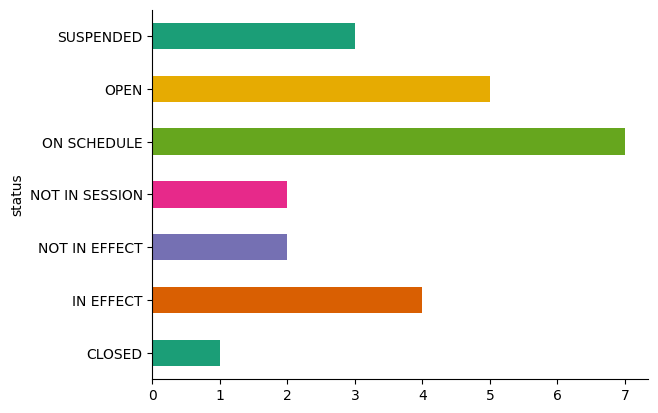

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Define Tests

In [6]:
def test_not_empty(data):
  """
  Test that data is not empty
  """
  return(not not data, "should not be empty")

def test_item(item):
  """
  Test that each item has the correct fields
  """

  result = {}

  #either 3 or four fields
  result["item should have 3 or 4 fields"] = ((len(item) >= 3) & (len(item) <= 4))

  #fail if there is some new type
  result["item in Schools, Collections, Alternate Side Parking"] = item["type"] in ["Schools", "Collections", "Alternate Side Parking"]

  #fail if missing status
  result["contains status"] = "status" in item
  #fail if missing details
  result["contains details"] = "details" in item

  if len(item) == 4:
    #fail if missing exception
    result["contains exceptionName"] = "exceptionName" in item

  return result

def test_date_range(days,from_date,to_date):
  """
  Test that the date range matches the count of days returned
  """

  #when to == from the delta is zero days
  #so we remove one to account for zeroth date in delta
  date_count = len(days) - 1

  start_date = datetime.datetime.strptime(from_date, '%Y-%m-%d')
  end_date = datetime.datetime.strptime(to_date, '%Y-%m-%d')
  delta = end_date - start_date

  return(date_count == delta.days, "date range should equal count of days returned, accounting for zeroth date in range")


# Test Results Dump

In [ ]:
## Dump Out Test Table
## This is a row by row test dump, run this if you dont' get the pretty data report

print(f"from_date: {from_date}")
print(f"to_date: {to_date}")

print(test_not_empty(response.text))

print(test_not_empty(json_data))

print(test_date_range(json_data["days"],from_date,to_date))

# this should be a parameterized test
for day in json_data["days"]:
  print(day)
  for item in day["items"]:
    print(test_item(item))


